In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf,read_raw_edf,read_raw_gdf,read_raw_fif
from mne.datasets import eegbci
from mne.decoding import CSP

In [4]:
def get_data():
    #path = "dataset\\bci_dataset\\train"
    #2b path 
    path = "dataset\\2b_moabb\\train"
    #2b file
    test_path = "dataset\\2b_moabb\\train\\0-raw.fif"
    #2a path
    #path = "dataset\\2amoabb\\train"
    
    #listed all data into list
    files = os.listdir(path)
    data_path = []
    for f in files:
        file = os.path.join(path,f)
        data_path.append(file)
        
    
    #tmin, tmax = -0.2, 0.4
    tmin, tmax = 1, 2
    event_id = dict(left=1, right = 2)

    #first is all data path second is one file
    #All subject
    raw = concatenate_raws([read_raw_fif(f, preload=True) for f in data_path])
    #one subject
    #raw = concatenate_raws([read_raw_fif(test_path, preload=True)])
    
    
    raw_data = raw.copy()
    print(raw_data.info)
    # strip channel names of "." characters
    raw_data.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    #skip_by_annotation='edge'
    raw_data.filter(l_freq=0.5, h_freq=100,skip_by_annotation='edge')
    raw_data.notch_filter(50)

    events, _ = events_from_annotations(raw_data)
    print(events)
    
    picks = pick_types(raw_data.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
    print(picks)
    #delete eog band
    #picks = np.delete(picks,[3,4,5])
    
    # Read epochs (train will be done only between 1 and 2s)
    # reject_criteria = dict( eeg=100e-6)       # 100 µV
    epochs = Epochs(raw_data, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None,preload=True)
    #epochs.crop(tmin=1., tmax=None)
    labels = epochs.events[:, -1]-1
    return epochs.get_data(), labels,epochs,raw_data


epochs_data, labels,epochs1,raw= get_data()

Opening raw data file dataset\2b_moabb\train\0-raw.fif...
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Opening raw data file dataset\2b_moabb\train\1-raw.fif...
    Range : 0 ... 552451 =      0.000 ...  2209.804 secs
Ready.
Reading 0 ... 552451  =      0.000 ...  2209.804 secs...
Opening raw data file dataset\2b_moabb\train\10-raw.fif...
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Opening raw data file dataset\2b_moabb\train\11-raw.fif...
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Opening raw data file dataset\2b_moabb\train\12-raw.fif...
    Range : 0 ... 464674 =      0.000 ...  1858.696 secs
Ready.
Reading 0 ... 464674  =      0.000 ...  1858.696 secs...
Opening raw data file dataset\2b_moabb\train\13-raw.fif...
    Range : 0 ... 464674 =      0.000 ...  

In [15]:
# 280 events(epoch)
# 22 channel
# 256 Time(samples)
#(event,channel,time)
print(epochs_data.shape)
print(labels.shape)
print(epochs_data.shape[1])
print(labels)
print(raw.info['ch_names'])
print(raw.info['nchan'])


(6520, 3, 251)
(6520,)
3
[0 1 0 ... 0 1 0]
['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3', 'stim']
7


In [16]:
'''print(epochs1)
epochs1.plot()
epochs1.plot_psd(fmax=50)'''

'print(epochs1)\nepochs1.plot()\nepochs1.plot_psd(fmax=50)'

In [17]:
import torch   
import torch.optim as optim  
from torch.utils.data import Dataset, DataLoader  
from torch.utils.data import Subset  
from torch import nn  
import torch.nn.functional as F  
from torch.utils.data import RandomSampler  
from torch.utils.data import SequentialSampler  

from common import EpochsDataset  

cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data)
train_idx, test_idx = next(cv_split)


def scale(X):
    """Standard scaling of data along the last dimention.
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    return X / 2e-5

dataset = EpochsDataset(epochs_data, labels, transform=None)


ds_train, ds_valid = Subset(dataset, train_idx), Subset(dataset, test_idx)

batch_size_train = len(ds_train)
batch_size_valid = len(ds_valid)
sampler_train = RandomSampler(ds_train)
sampler_valid = SequentialSampler(ds_valid)

# create loaders
num_workers = 0
loader_train = \
    DataLoader(ds_train, batch_size=batch_size_train,
               num_workers=num_workers,shuffle=True)
loader_valid = \
    DataLoader(ds_valid, batch_size=batch_size_valid,
               num_workers=num_workers,shuffle=True)

In [18]:
class First_SingleNet(nn.Module):
    def __init__(self):
        super().__init__()

        # define model architecture
        # torch.Size([36, 1, 64, 256])
        # temporal convolutional kernel 25 filter with size(11,1)
        #input [224, 1, 22, 256]
        # new input [96, 1, 3, 151]
        #A block
        
        #Temporal torch.Size([5216, 8, 1, 151])
        self.temporalConv = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(3,1),stride=1)
        #Spatial torch.Size([5216, 8, 1, 151])
        self.spatialConv = nn.Conv2d(in_channels=8,out_channels=8,kernel_size=(1,1),stride=1)
        #Maxx torch.Size([5216, 41, 1, 2])
        self.maxPooling = nn.MaxPool2d((1,3))
        
        
        # 1st convo output [25,1,371]
        #input [224, 8, 1, 85]
        # new input [96, 8, 1, 50]
        
        self.firstConv = nn.Conv2d(in_channels=8, out_channels=8,kernel_size=(1,1))
        self.secondConv = nn.Conv2d(in_channels=8, out_channels=33,kernel_size=(1,1))
        self.thirdConv = nn.Conv2d(in_channels=33,out_channels=33,kernel_size=(1,1))
        self.maxPooling2 = nn.MaxPool2d((1,3))
        # out Secondblock torch.Size([5216, 41, 1, 16])
        
        #C block
        #input [224, 41, 1, 28]
        #new input [96, 41, 1, 16]
        
        self.classify = nn.Conv2d(in_channels=41,out_channels=41,kernel_size=(1,11)) 
        #Classify torch.Size([5216, 41, 1, 6])
        self.maxPooling3 = nn.MaxPool2d((1,3))
        #Maxx torch.Size([5216, 41, 1, 2])
        self.flatten = nn.Flatten()
        #flatter torch.Size([5216, 82])
        self.elu = nn.ELU()
        #elu torch.Size([5216, 82])
        self.fully = nn.Linear(205,2) 
        #fully torch.Size([5216, 2])
        
        
    def forward(self, x):
        #Conv1d(1,ch,kernel_size=10) on tensor [batch=1, channels=1, time=400]
        
        x = self.temporalConv(x)
        x= self.spatialConv(x)
        x = self.elu(x)
        x = self.maxPooling(x)

        
        out2 = self.firstConv(x)
        out2 = self.secondConv(out2)
        out2 = self.thirdConv(out2)
        out3 = torch.cat((x,out2),1)
        out3 = self.maxPooling2(out3)
        
        
        out3 = self.classify(out3)
        out3 = self.maxPooling3(out3)
        out3 = self.flatten(out3)
        out3 = self.elu(out3)
        out3 = self.fully(out3)
        out3 = self.elu(out3)
        out3 = F.log_softmax(out3, dim=1)
        
        return out3

In [19]:
class SingleNet(nn.Module):
    def __init__(self):
        super().__init__()

        # define model architecture
        # torch.Size([36, 1, 64, 256])
        # temporal convolutional kernel 25 filter with size(11,1)
        #input [224, 1, 22, 256]
        # new input [96, 1, 3, 151]
        #A block
        
        #Temporal torch.Size([5216, 8, 1, 151])
        
        self.temporalConv = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(1,3))
        self.batchnorm1 = nn.BatchNorm2d(8, False)
        #Spatial torch.Size([5216, 8, 1, 151])
        self.spatialConv = nn.Conv2d(in_channels=8,out_channels=8,kernel_size=(3,1))
        self.batchnorm6 = nn.BatchNorm2d(8, False)
        #Maxx torch.Size([5216, 41, 1, 2])
        self.maxPooling = nn.MaxPool2d((1,3))
        
        #B block
        # 1st convo output [25,1,371]
        #input [224, 8, 1, 85]
        # new input [96, 8, 1, 50]
        
        self.firstConv = nn.Conv2d(in_channels=8, out_channels=8,kernel_size=(1,1))
        self.batchnorm2 = nn.BatchNorm2d(8, False)
        self.secondConv = nn.Conv2d(in_channels=8, out_channels=33,kernel_size=(1,1))
        self.batchnorm3 = nn.BatchNorm2d(33, False)
        self.maxPooling2 = nn.MaxPool2d((1,3))
        # out Secondblock torch.Size([5216, 41, 1, 16])
        
        #C block
        #input [224, 41, 1, 28]
        #new input [96, 41, 1, 16]
        
        self.classify = nn.Conv2d(in_channels=41,out_channels=41,kernel_size=(1,11)) 
        self.batchnorm5 = nn.BatchNorm2d(41, False)
        #Classify torch.Size([5216, 41, 1, 6])
        self.maxPooling3 = nn.MaxPool2d((1,3))
        #Maxx torch.Size([5216, 41, 1, 2])
        self.flatten = nn.Flatten()
        #flatter torch.Size([5216, 82])
        self.elu = nn.ELU()
        #elu torch.Size([5216, 82])
        self.fully = nn.Linear(9799,2) 
        #fully torch.Size([5216, 2])
        
        
    def forward(self, x):
        #Conv1d(1,ch,kernel_size=10) on tensor [batch=1, channels=1, time=400]
        
        x = self.temporalConv(x)
        x = self.elu(x)
        x = self.batchnorm1(x)
        print(x.shape)
        x = F.dropout(x, 0.5)   
        x= self.spatialConv(x)
        x = self.elu(x)
        x = self.batchnorm6(x)
        x = F.dropout(x, 0.5)     
        x = self.maxPooling(x) 
        
        
        out2 = self.firstConv(x)
        out2 = self.elu(out2)
        out2 = self.batchnorm2(out2)
        out2 = F.dropout(out2, 0.5)  
        out2 = self.secondConv(out2)
        out2 = self.elu(out2)
        out2 = self.batchnorm3(out2)
        out2 = F.dropout(out2, 0.5)
        out3 = torch.cat((x,out2),1)
        out3 = self.maxPooling2(out3)
        
        
        out3 = self.classify(out3)
        out3 = self.elu(out3)
        out3 = self.batchnorm5(out3)
        out3 = F.dropout(out3, 0.5)
        out3 = self.maxPooling3(out3)
        out3 = self.flatten(out3)
        out3 = self.fully(out3)
        out3 = self.elu(out3)
        out3 = F.log_softmax(out3, dim=1)
        
        
        return out3

In [20]:
class CNN(nn.Module):
    def __init__(self,kernel_size=3,dilation=1):
        super(CNN, self).__init__()
        self.pad = (kernel_size - 1) * dilation
        self.temporal= nn.Conv2d(in_channels=1,out_channels=25,kernel_size=(1,1),stride=1)
        self.leaky = nn.LeakyReLU()
        self.spatial = nn.Conv2d(in_channels=25,out_channels=25,kernel_size=(3,1),stride=1)
        self.batchnorm1 = nn.BatchNorm2d(25,False)
        self.maxPooling = nn.MaxPool2d((1,3))
        
        self.conv3 = nn.Conv2d(in_channels=25,out_channels=50,kernel_size=(1,11),stride=1)
        self.conv4 = nn.Conv2d(in_channels=50,out_channels=100,kernel_size=(1,11),stride=1)
        self.batchnorm2 = nn.BatchNorm2d(100,False)
        
        self.conv5 = nn.Conv2d(in_channels=100,out_channels=200,kernel_size=(1,11),stride=1)
        self.maxPooling2 = nn.MaxPool2d((1,2))
        self.flatten = nn.Flatten()
        self.fully = nn.Linear(400,2) 
        
    def forward(self,x):
        print(x.shape)
        x = self.temporal(x)
        x = self.leaky(x)
        x = F.dropout2d(x,0.5)
        
        
        x = self.spatial(x)
        x = self.batchnorm1(x)
        x = self.leaky(x)
        x = self.maxPooling(x)
        
        x = self.conv3(x)
        x = self.leaky(x)
        x = F.dropout2d(x,0.5)
        x = self.maxPooling(x)
        
        x = self.conv4(x)
        x = self.batchnorm2(x)
        x = self.leaky(x)
        x = F.dropout2d(x,0.5)
        x = self.maxPooling(x)
        x = self.flatten(x)
        out = self.fully(x)
        return out

In [21]:
#device = 'cuda'
device = 'cpu'
#model = SingleNet()
model = CNN()

for index ,(x,y) in enumerate(loader_train):
    print(x.shape)
    x = x.to(device=device,dtype=torch.float32)
    model(x)


torch.Size([5216, 1, 3, 251])
torch.Size([5216, 1, 3, 251])


In [22]:
# Train
from common import train

lr = 1e-4
n_epochs = 300
patience = 300
weight_name = "CNN_2class_allsubject"
model.to(device=device) 
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

best_model,train_loss,valid_loss = train(model, loader_train, loader_valid, optimizer,criterion,n_epochs, patience, device,weight_name)


Starting epoch 1 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.79: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


---  Accuracy Training set : 49.87 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


---  Accuracy Validation set: 50.69 % 


best val loss inf -> 0.6934

Starting epoch 2 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.78: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


---  Accuracy Training set : 49.33 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


---  Accuracy Validation set: 51.53 % 


best val loss 0.6934 -> 0.6933

Starting epoch 3 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.77: 100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


---  Accuracy Training set : 50.02 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


---  Accuracy Validation set: 50.08 % 

Waiting += 1

Starting epoch 4 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.76: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


---  Accuracy Training set : 50.12 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


---  Accuracy Validation set: 51.61 % 


best val loss 0.6933 -> 0.6931

Starting epoch 5 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.76: 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


---  Accuracy Training set : 50.38 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


---  Accuracy Validation set: 51.23 % 

Waiting += 1

Starting epoch 6 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.75: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


---  Accuracy Training set : 50.71 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


---  Accuracy Validation set: 50.92 % 

Waiting += 1

Starting epoch 7 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.76: 100%|██████████| 1/1 [00:04<00:00,  4.44s/it]


---  Accuracy Training set : 50.36 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


---  Accuracy Validation set: 49.46 % 

Waiting += 1

Starting epoch 8 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.75: 100%|██████████| 1/1 [00:04<00:00,  4.36s/it]


---  Accuracy Training set : 49.64 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


---  Accuracy Validation set: 50.23 % 

Waiting += 1

Starting epoch 9 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.75: 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


---  Accuracy Training set : 49.21 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


---  Accuracy Validation set: 49.46 % 

Waiting += 1

Starting epoch 10 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.74: 100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


---  Accuracy Training set : 49.81 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


---  Accuracy Validation set: 49.39 % 

Waiting += 1

Starting epoch 11 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.74: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


---  Accuracy Training set : 50.59 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


---  Accuracy Validation set: 51.69 % 


best val loss 0.6931 -> 0.6915

Starting epoch 12 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.74: 100%|██████████| 1/1 [00:03<00:00,  3.89s/it]


---  Accuracy Training set : 49.62 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


---  Accuracy Validation set: 49.77 % 

Waiting += 1

Starting epoch 13 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:04<00:00,  4.37s/it]


---  Accuracy Training set : 49.85 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


---  Accuracy Validation set: 49.92 % 

Waiting += 1

Starting epoch 14 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


---  Accuracy Training set : 50.82 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


---  Accuracy Validation set: 50.15 % 

Waiting += 1

Starting epoch 15 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


---  Accuracy Training set : 50.29 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


---  Accuracy Validation set: 50.08 % 

Waiting += 1

Starting epoch 16 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.74: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


---  Accuracy Training set : 49.42 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 17 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


---  Accuracy Training set : 50.63 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


---  Accuracy Validation set: 49.85 % 

Waiting += 1

Starting epoch 18 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


---  Accuracy Training set : 50.27 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


---  Accuracy Validation set: 51.61 % 

Waiting += 1

Starting epoch 19 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


---  Accuracy Training set : 49.67 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


---  Accuracy Validation set: 50.61 % 

Waiting += 1

Starting epoch 20 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:05<00:00,  5.07s/it]


---  Accuracy Training set : 50.13 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


---  Accuracy Validation set: 50.38 % 

Waiting += 1

Starting epoch 21 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:05<00:00,  5.24s/it]


---  Accuracy Training set : 50.31 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


---  Accuracy Validation set: 50.08 % 

Waiting += 1

Starting epoch 22 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:05<00:00,  5.44s/it]


---  Accuracy Training set : 50.56 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


---  Accuracy Validation set: 50.92 % 

Waiting += 1

Starting epoch 23 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:04<00:00,  4.91s/it]


---  Accuracy Training set : 50.29 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


---  Accuracy Validation set: 50.00 % 

Waiting += 1

Starting epoch 24 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it]


---  Accuracy Training set : 49.60 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


---  Accuracy Validation set: 50.69 % 

Waiting += 1

Starting epoch 25 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


---  Accuracy Training set : 49.98 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


---  Accuracy Validation set: 49.92 % 

Waiting += 1

Starting epoch 26 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


---  Accuracy Training set : 49.04 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


---  Accuracy Validation set: 48.16 % 

Waiting += 1

Starting epoch 27 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


---  Accuracy Training set : 49.21 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


---  Accuracy Validation set: 47.32 % 

Waiting += 1

Starting epoch 28 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


---  Accuracy Training set : 49.88 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


---  Accuracy Validation set: 52.15 % 

Waiting += 1

Starting epoch 29 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


---  Accuracy Training set : 49.21 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


---  Accuracy Validation set: 47.70 % 

Waiting += 1

Starting epoch 30 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]


---  Accuracy Training set : 50.46 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


---  Accuracy Validation set: 50.84 % 

Waiting += 1

Starting epoch 31 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


---  Accuracy Training set : 49.33 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


---  Accuracy Validation set: 50.31 % 

Waiting += 1

Starting epoch 32 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:04<00:00,  4.89s/it]


---  Accuracy Training set : 49.21 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


---  Accuracy Validation set: 50.15 % 

Waiting += 1

Starting epoch 33 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:05<00:00,  5.11s/it]


---  Accuracy Training set : 49.58 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


---  Accuracy Validation set: 49.00 % 

Waiting += 1

Starting epoch 34 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


---  Accuracy Training set : 51.04 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


---  Accuracy Validation set: 50.69 % 

Waiting += 1

Starting epoch 35 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:04<00:00,  4.86s/it]


---  Accuracy Training set : 49.10 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


---  Accuracy Validation set: 51.30 % 

Waiting += 1

Starting epoch 36 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.77s/it]


---  Accuracy Training set : 50.25 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


---  Accuracy Validation set: 49.92 % 

Waiting += 1

Starting epoch 37 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


---  Accuracy Training set : 50.02 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


---  Accuracy Validation set: 47.16 % 

Waiting += 1

Starting epoch 38 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


---  Accuracy Training set : 49.69 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


---  Accuracy Validation set: 50.54 % 

Waiting += 1

Starting epoch 39 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]


---  Accuracy Training set : 48.91 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


---  Accuracy Validation set: 52.91 % 

Waiting += 1

Starting epoch 40 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.73: 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


---  Accuracy Training set : 49.64 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


---  Accuracy Validation set: 47.55 % 

Waiting += 1

Starting epoch 41 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


---  Accuracy Training set : 49.94 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


---  Accuracy Validation set: 52.45 % 

Waiting += 1

Starting epoch 42 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


---  Accuracy Training set : 50.38 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.72: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 43 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


---  Accuracy Training set : 50.52 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


---  Accuracy Validation set: 49.62 % 

Waiting += 1

Starting epoch 44 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


---  Accuracy Training set : 49.94 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


---  Accuracy Validation set: 50.38 % 

Waiting += 1

Starting epoch 45 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


---  Accuracy Training set : 50.15 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.72: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


---  Accuracy Validation set: 49.46 % 

Waiting += 1

Starting epoch 46 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


---  Accuracy Training set : 48.85 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


---  Accuracy Validation set: 52.22 % 

Waiting += 1

Starting epoch 47 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


---  Accuracy Training set : 49.81 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


---  Accuracy Validation set: 50.84 % 

Waiting += 1

Starting epoch 48 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


---  Accuracy Training set : 49.50 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


---  Accuracy Validation set: 51.61 % 

Waiting += 1

Starting epoch 49 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


---  Accuracy Training set : 50.36 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


---  Accuracy Validation set: 49.46 % 

Waiting += 1

Starting epoch 50 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]


---  Accuracy Training set : 51.00 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


---  Accuracy Validation set: 49.85 % 

Waiting += 1

Starting epoch 51 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


---  Accuracy Training set : 49.58 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


---  Accuracy Validation set: 50.77 % 

Waiting += 1

Starting epoch 52 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]


---  Accuracy Training set : 49.04 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.72: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


---  Accuracy Validation set: 49.16 % 

Waiting += 1

Starting epoch 53 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:03<00:00,  4.00s/it]


---  Accuracy Training set : 49.92 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


---  Accuracy Validation set: 50.69 % 

Waiting += 1

Starting epoch 54 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]


---  Accuracy Training set : 50.86 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


---  Accuracy Validation set: 50.77 % 

Waiting += 1

Starting epoch 55 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]


---  Accuracy Training set : 50.35 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.72: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


---  Accuracy Validation set: 49.39 % 

Waiting += 1

Starting epoch 56 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


---  Accuracy Training set : 49.31 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


---  Accuracy Validation set: 49.39 % 

Waiting += 1

Starting epoch 57 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


---  Accuracy Training set : 50.10 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.72: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


---  Accuracy Validation set: 49.85 % 

Waiting += 1

Starting epoch 58 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


---  Accuracy Training set : 49.04 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


---  Accuracy Validation set: 51.00 % 

Waiting += 1

Starting epoch 59 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


---  Accuracy Training set : 50.29 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


---  Accuracy Validation set: 49.77 % 

Waiting += 1

Starting epoch 60 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


---  Accuracy Training set : 50.71 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


---  Accuracy Validation set: 51.07 % 

Waiting += 1

Starting epoch 61 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


---  Accuracy Training set : 50.23 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


---  Accuracy Validation set: 53.22 % 

Waiting += 1

Starting epoch 62 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:03<00:00,  3.89s/it]


---  Accuracy Training set : 50.67 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


---  Accuracy Validation set: 51.15 % 

Waiting += 1

Starting epoch 63 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]


---  Accuracy Training set : 50.13 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.73: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


---  Accuracy Validation set: 47.62 % 

Waiting += 1

Starting epoch 64 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


---  Accuracy Training set : 49.92 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


---  Accuracy Validation set: 49.54 % 

Waiting += 1

Starting epoch 65 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it]


---  Accuracy Training set : 51.30 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


---  Accuracy Validation set: 50.46 % 

Waiting += 1

Starting epoch 66 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


---  Accuracy Training set : 49.81 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


---  Accuracy Validation set: 49.62 % 

Waiting += 1

Starting epoch 67 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


---  Accuracy Training set : 49.88 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


---  Accuracy Validation set: 50.92 % 

Waiting += 1

Starting epoch 68 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


---  Accuracy Training set : 49.16 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.72: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


---  Accuracy Validation set: 49.39 % 

Waiting += 1

Starting epoch 69 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


---  Accuracy Training set : 49.08 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


---  Accuracy Validation set: 50.92 % 

Waiting += 1

Starting epoch 70 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.80s/it]


---  Accuracy Training set : 50.63 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


---  Accuracy Validation set: 49.62 % 

Waiting += 1

Starting epoch 71 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


---  Accuracy Training set : 50.27 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


---  Accuracy Validation set: 50.54 % 

Waiting += 1

Starting epoch 72 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


---  Accuracy Training set : 49.54 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.72: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


---  Accuracy Validation set: 51.00 % 

Waiting += 1

Starting epoch 73 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it]


---  Accuracy Training set : 49.39 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


---  Accuracy Validation set: 50.54 % 

Waiting += 1

Starting epoch 74 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.83s/it]


---  Accuracy Training set : 50.81 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


---  Accuracy Validation set: 50.61 % 

Waiting += 1

Starting epoch 75 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.85s/it]


---  Accuracy Training set : 51.74 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.72: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


---  Accuracy Validation set: 49.39 % 

Waiting += 1

Starting epoch 76 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


---  Accuracy Training set : 50.50 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


---  Accuracy Validation set: 51.92 % 

Waiting += 1

Starting epoch 77 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it]


---  Accuracy Training set : 49.67 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


---  Accuracy Validation set: 52.38 % 

Waiting += 1

Starting epoch 78 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.97s/it]


---  Accuracy Training set : 49.73 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


---  Accuracy Validation set: 50.23 % 

Waiting += 1

Starting epoch 79 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:05<00:00,  5.45s/it]


---  Accuracy Training set : 50.25 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.72: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


---  Accuracy Validation set: 47.32 % 

Waiting += 1

Starting epoch 80 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.72: 100%|██████████| 1/1 [00:04<00:00,  4.87s/it]


---  Accuracy Training set : 48.75 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 81 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


---  Accuracy Training set : 49.67 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


---  Accuracy Validation set: 49.77 % 

Waiting += 1

Starting epoch 82 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


---  Accuracy Training set : 50.25 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


---  Accuracy Validation set: 49.62 % 

Waiting += 1

Starting epoch 83 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


---  Accuracy Training set : 50.44 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


---  Accuracy Validation set: 50.46 % 

Waiting += 1

Starting epoch 84 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.42s/it]


---  Accuracy Training set : 49.56 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


---  Accuracy Validation set: 48.54 % 

Waiting += 1

Starting epoch 85 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.65s/it]


---  Accuracy Training set : 48.73 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


---  Accuracy Validation set: 50.92 % 

Waiting += 1

Starting epoch 86 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]


---  Accuracy Training set : 50.35 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


---  Accuracy Validation set: 49.31 % 

Waiting += 1

Starting epoch 87 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


---  Accuracy Training set : 51.07 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


---  Accuracy Validation set: 50.77 % 

Waiting += 1

Starting epoch 88 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


---  Accuracy Training set : 50.02 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


---  Accuracy Validation set: 50.31 % 

Waiting += 1

Starting epoch 89 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


---  Accuracy Training set : 50.25 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


---  Accuracy Validation set: 51.76 % 

Waiting += 1

Starting epoch 90 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.71s/it]


---  Accuracy Training set : 49.46 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


---  Accuracy Validation set: 49.77 % 

Waiting += 1

Starting epoch 91 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.42s/it]


---  Accuracy Training set : 49.58 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


---  Accuracy Validation set: 51.84 % 

Waiting += 1

Starting epoch 92 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.92s/it]


---  Accuracy Training set : 49.65 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.72: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


---  Accuracy Validation set: 48.85 % 

Waiting += 1

Starting epoch 93 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.78s/it]


---  Accuracy Training set : 50.90 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


---  Accuracy Validation set: 50.23 % 

Waiting += 1

Starting epoch 94 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


---  Accuracy Training set : 50.19 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


---  Accuracy Validation set: 49.46 % 

Waiting += 1

Starting epoch 95 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:05<00:00,  5.39s/it]


---  Accuracy Training set : 49.50 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


---  Accuracy Validation set: 50.54 % 

Waiting += 1

Starting epoch 96 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:05<00:00,  5.22s/it]


---  Accuracy Training set : 50.17 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


---  Accuracy Validation set: 51.15 % 

Waiting += 1

Starting epoch 97 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.34s/it]


---  Accuracy Training set : 49.75 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


---  Accuracy Validation set: 51.38 % 

Waiting += 1

Starting epoch 98 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.80s/it]


---  Accuracy Training set : 50.08 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


---  Accuracy Validation set: 50.00 % 

Waiting += 1

Starting epoch 99 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.98s/it]


---  Accuracy Training set : 49.81 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


---  Accuracy Validation set: 50.61 % 

Waiting += 1

Starting epoch 100 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


---  Accuracy Training set : 49.52 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


---  Accuracy Validation set: 47.93 % 

Waiting += 1

Starting epoch 101 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it]


---  Accuracy Training set : 49.41 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


---  Accuracy Validation set: 47.62 % 

Waiting += 1

Starting epoch 102 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


---  Accuracy Training set : 50.38 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


---  Accuracy Validation set: 51.61 % 

Waiting += 1

Starting epoch 103 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


---  Accuracy Training set : 49.73 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


---  Accuracy Validation set: 51.38 % 

Waiting += 1

Starting epoch 104 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.34s/it]


---  Accuracy Training set : 49.87 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


---  Accuracy Validation set: 51.92 % 

Waiting += 1

Starting epoch 105 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


---  Accuracy Training set : 50.98 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


---  Accuracy Validation set: 49.62 % 

Waiting += 1

Starting epoch 106 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


---  Accuracy Training set : 50.50 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


---  Accuracy Validation set: 49.85 % 

Waiting += 1

Starting epoch 107 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.86s/it]


---  Accuracy Training set : 50.40 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


---  Accuracy Validation set: 49.46 % 

Waiting += 1

Starting epoch 108 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


---  Accuracy Training set : 50.27 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


---  Accuracy Validation set: 46.47 % 

Waiting += 1

Starting epoch 109 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.55s/it]


---  Accuracy Training set : 50.36 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


---  Accuracy Validation set: 49.39 % 

Waiting += 1

Starting epoch 110 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]


---  Accuracy Training set : 49.42 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


---  Accuracy Validation set: 48.01 % 

Waiting += 1

Starting epoch 111 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.32s/it]


---  Accuracy Training set : 50.10 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


---  Accuracy Validation set: 49.77 % 

Waiting += 1

Starting epoch 112 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


---  Accuracy Training set : 49.10 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 113 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


---  Accuracy Training set : 49.46 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


---  Accuracy Validation set: 49.46 % 

Waiting += 1

Starting epoch 114 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it]


---  Accuracy Training set : 50.31 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


---  Accuracy Validation set: 49.77 % 

Waiting += 1

Starting epoch 115 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


---  Accuracy Training set : 50.21 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


---  Accuracy Validation set: 50.38 % 

Waiting += 1

Starting epoch 116 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


---  Accuracy Training set : 50.92 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


---  Accuracy Validation set: 49.39 % 

Waiting += 1

Starting epoch 117 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it]


---  Accuracy Training set : 48.77 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


---  Accuracy Validation set: 50.00 % 

Waiting += 1

Starting epoch 118 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


---  Accuracy Training set : 49.81 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


---  Accuracy Validation set: 47.16 % 

Waiting += 1

Starting epoch 119 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.32s/it]


---  Accuracy Training set : 49.64 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


---  Accuracy Validation set: 52.84 % 

Waiting += 1

Starting epoch 120 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it]


---  Accuracy Training set : 48.70 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


---  Accuracy Validation set: 49.92 % 

Waiting += 1

Starting epoch 121 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]


---  Accuracy Training set : 50.61 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


---  Accuracy Validation set: 49.23 % 

Waiting += 1

Starting epoch 122 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


---  Accuracy Training set : 49.44 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


---  Accuracy Validation set: 50.00 % 

Waiting += 1

Starting epoch 123 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


---  Accuracy Training set : 50.13 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


---  Accuracy Validation set: 48.85 % 

Waiting += 1

Starting epoch 124 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]


---  Accuracy Training set : 49.35 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


---  Accuracy Validation set: 50.54 % 

Waiting += 1

Starting epoch 125 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.65s/it]


---  Accuracy Training set : 49.54 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


---  Accuracy Validation set: 49.46 % 

Waiting += 1

Starting epoch 126 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.57s/it]


---  Accuracy Training set : 50.15 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


---  Accuracy Validation set: 52.38 % 

Waiting += 1

Starting epoch 127 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.71: 100%|██████████| 1/1 [00:05<00:00,  5.18s/it]


---  Accuracy Training set : 49.06 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


---  Accuracy Validation set: 50.00 % 

Waiting += 1

Starting epoch 128 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:05<00:00,  5.18s/it]


---  Accuracy Training set : 48.73 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


---  Accuracy Validation set: 49.39 % 

Waiting += 1

Starting epoch 129 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:05<00:00,  5.10s/it]


---  Accuracy Training set : 50.71 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


---  Accuracy Validation set: 52.45 % 

Waiting += 1

Starting epoch 130 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


---  Accuracy Training set : 49.90 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 131 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it]


---  Accuracy Training set : 50.27 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


---  Accuracy Validation set: 50.00 % 

Waiting += 1

Starting epoch 132 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]


---  Accuracy Training set : 49.50 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 133 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


---  Accuracy Training set : 49.39 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


---  Accuracy Validation set: 50.38 % 

Waiting += 1

Starting epoch 134 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


---  Accuracy Training set : 49.85 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


---  Accuracy Validation set: 50.00 % 

Waiting += 1

Starting epoch 135 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


---  Accuracy Training set : 48.77 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


---  Accuracy Validation set: 49.08 % 

Waiting += 1

Starting epoch 136 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


---  Accuracy Training set : 50.67 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


---  Accuracy Validation set: 52.22 % 

Waiting += 1

Starting epoch 137 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


---  Accuracy Training set : 49.27 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


---  Accuracy Validation set: 51.38 % 

Waiting += 1

Starting epoch 138 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


---  Accuracy Training set : 50.54 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


---  Accuracy Validation set: 51.23 % 

Waiting += 1

Starting epoch 139 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


---  Accuracy Training set : 50.06 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


---  Accuracy Validation set: 49.85 % 

Waiting += 1

Starting epoch 140 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


---  Accuracy Training set : 50.54 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


---  Accuracy Validation set: 51.76 % 

Waiting += 1

Starting epoch 141 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


---  Accuracy Training set : 51.15 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


---  Accuracy Validation set: 52.38 % 

Waiting += 1

Starting epoch 142 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]


---  Accuracy Training set : 51.55 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


---  Accuracy Validation set: 49.54 % 

Waiting += 1

Starting epoch 143 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


---  Accuracy Training set : 49.54 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


---  Accuracy Validation set: 47.39 % 

Waiting += 1

Starting epoch 144 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:05<00:00,  5.16s/it]


---  Accuracy Training set : 48.87 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


---  Accuracy Validation set: 47.70 % 

Waiting += 1

Starting epoch 145 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


---  Accuracy Training set : 49.48 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


---  Accuracy Validation set: 46.01 % 

Waiting += 1

Starting epoch 146 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


---  Accuracy Training set : 50.17 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


---  Accuracy Validation set: 48.54 % 

Waiting += 1

Starting epoch 147 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]


---  Accuracy Training set : 49.27 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


---  Accuracy Validation set: 52.07 % 

Waiting += 1

Starting epoch 148 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


---  Accuracy Training set : 49.37 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


---  Accuracy Validation set: 49.31 % 

Waiting += 1

Starting epoch 149 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.77s/it]


---  Accuracy Training set : 49.14 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


---  Accuracy Validation set: 49.92 % 

Waiting += 1

Starting epoch 150 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


---  Accuracy Training set : 49.90 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


---  Accuracy Validation set: 47.93 % 

Waiting += 1

Starting epoch 151 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


---  Accuracy Training set : 49.35 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


---  Accuracy Validation set: 49.46 % 

Waiting += 1

Starting epoch 152 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


---  Accuracy Training set : 51.17 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 153 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


---  Accuracy Training set : 50.00 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


---  Accuracy Validation set: 51.53 % 

Waiting += 1

Starting epoch 154 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


---  Accuracy Training set : 50.88 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


---  Accuracy Validation set: 49.54 % 

Waiting += 1

Starting epoch 155 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.30s/it]


---  Accuracy Training set : 50.02 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


---  Accuracy Validation set: 49.85 % 

Waiting += 1

Starting epoch 156 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


---  Accuracy Training set : 49.87 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


---  Accuracy Validation set: 50.69 % 

Waiting += 1

Starting epoch 157 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


---  Accuracy Training set : 51.32 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


---  Accuracy Validation set: 49.00 % 

Waiting += 1

Starting epoch 158 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it]


---  Accuracy Training set : 49.92 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


---  Accuracy Validation set: 51.38 % 

Waiting += 1

Starting epoch 159 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it]


---  Accuracy Training set : 49.75 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


---  Accuracy Validation set: 50.61 % 

Waiting += 1

Starting epoch 160 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


---  Accuracy Training set : 49.06 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


---  Accuracy Validation set: 51.23 % 

Waiting += 1

Starting epoch 161 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


---  Accuracy Training set : 50.92 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


---  Accuracy Validation set: 51.46 % 

Waiting += 1

Starting epoch 162 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.58s/it]


---  Accuracy Training set : 50.29 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


---  Accuracy Validation set: 50.31 % 

Waiting += 1

Starting epoch 163 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.31s/it]


---  Accuracy Training set : 51.21 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


---  Accuracy Validation set: 47.32 % 

Waiting += 1

Starting epoch 164 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:05<00:00,  5.56s/it]


---  Accuracy Training set : 50.40 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


---  Accuracy Validation set: 53.91 % 

Waiting += 1

Starting epoch 165 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.34s/it]


---  Accuracy Training set : 49.64 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


---  Accuracy Validation set: 48.62 % 

Waiting += 1

Starting epoch 166 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it]


---  Accuracy Training set : 49.79 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


---  Accuracy Validation set: 50.23 % 

Waiting += 1

Starting epoch 167 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


---  Accuracy Training set : 50.06 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


---  Accuracy Validation set: 52.38 % 

Waiting += 1

Starting epoch 168 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


---  Accuracy Training set : 50.59 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


---  Accuracy Validation set: 49.69 % 

Waiting += 1

Starting epoch 169 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


---  Accuracy Training set : 50.10 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


---  Accuracy Validation set: 51.30 % 

Waiting += 1

Starting epoch 170 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.79s/it]


---  Accuracy Training set : 50.33 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


---  Accuracy Validation set: 47.32 % 

Waiting += 1

Starting epoch 171 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:05<00:00,  5.07s/it]


---  Accuracy Training set : 50.48 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


---  Accuracy Validation set: 50.08 % 

Waiting += 1

Starting epoch 172 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it]


---  Accuracy Training set : 49.00 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


---  Accuracy Validation set: 50.08 % 

Waiting += 1

Starting epoch 173 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


---  Accuracy Training set : 50.56 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


---  Accuracy Validation set: 50.61 % 

Waiting += 1

Starting epoch 174 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.55s/it]


---  Accuracy Training set : 50.75 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 175 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


---  Accuracy Training set : 50.59 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


---  Accuracy Validation set: 50.61 % 

Waiting += 1

Starting epoch 176 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it]


---  Accuracy Training set : 49.81 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


---  Accuracy Validation set: 49.62 % 

Waiting += 1

Starting epoch 177 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.59s/it]


---  Accuracy Training set : 50.10 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


---  Accuracy Validation set: 49.23 % 

Waiting += 1

Starting epoch 178 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


---  Accuracy Training set : 50.10 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 179 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.77s/it]


---  Accuracy Training set : 49.83 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


---  Accuracy Validation set: 48.93 % 

Waiting += 1

Starting epoch 180 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


---  Accuracy Training set : 50.65 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


---  Accuracy Validation set: 48.01 % 

Waiting += 1

Starting epoch 181 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


---  Accuracy Training set : 50.29 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


---  Accuracy Validation set: 48.62 % 

Waiting += 1

Starting epoch 182 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.57s/it]


---  Accuracy Training set : 48.12 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


---  Accuracy Validation set: 49.92 % 

Waiting += 1

Starting epoch 183 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.79s/it]


---  Accuracy Training set : 48.85 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


---  Accuracy Validation set: 51.46 % 

Waiting += 1

Starting epoch 184 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


---  Accuracy Training set : 49.65 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


---  Accuracy Validation set: 48.77 % 

Waiting += 1

Starting epoch 185 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it]


---  Accuracy Training set : 50.79 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.71: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


---  Accuracy Validation set: 46.93 % 

Waiting += 1

Starting epoch 186 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


---  Accuracy Training set : 49.50 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


---  Accuracy Validation set: 51.00 % 

Waiting += 1

Starting epoch 187 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


---  Accuracy Training set : 49.31 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


---  Accuracy Validation set: 49.62 % 

Waiting += 1

Starting epoch 188 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.44s/it]


---  Accuracy Training set : 50.71 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 189 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]


---  Accuracy Training set : 50.19 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


---  Accuracy Validation set: 50.84 % 

Waiting += 1

Starting epoch 190 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.34s/it]


---  Accuracy Training set : 50.02 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


---  Accuracy Validation set: 48.77 % 

Waiting += 1

Starting epoch 191 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it]


---  Accuracy Training set : 49.44 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


---  Accuracy Validation set: 51.84 % 

Waiting += 1

Starting epoch 192 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


---  Accuracy Training set : 49.73 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


---  Accuracy Validation set: 51.23 % 

Waiting += 1

Starting epoch 193 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it]


---  Accuracy Training set : 49.37 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 194 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]


---  Accuracy Training set : 50.92 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


---  Accuracy Validation set: 50.69 % 

Waiting += 1

Starting epoch 195 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


---  Accuracy Training set : 50.52 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


---  Accuracy Validation set: 49.23 % 

Waiting += 1

Starting epoch 196 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


---  Accuracy Training set : 50.59 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


---  Accuracy Validation set: 49.85 % 

Waiting += 1

Starting epoch 197 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]


---  Accuracy Training set : 49.71 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


---  Accuracy Validation set: 51.00 % 

Waiting += 1

Starting epoch 198 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


---  Accuracy Training set : 50.19 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


---  Accuracy Validation set: 50.08 % 

Waiting += 1

Starting epoch 199 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


---  Accuracy Training set : 50.42 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


---  Accuracy Validation set: 50.31 % 

Waiting += 1

Starting epoch 200 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


---  Accuracy Training set : 50.13 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


---  Accuracy Validation set: 49.39 % 

Waiting += 1

Starting epoch 201 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]


---  Accuracy Training set : 50.42 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


---  Accuracy Validation set: 49.62 % 

Waiting += 1

Starting epoch 202 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.32s/it]


---  Accuracy Training set : 50.82 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


---  Accuracy Validation set: 51.00 % 

Waiting += 1

Starting epoch 203 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it]


---  Accuracy Training set : 49.75 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


---  Accuracy Validation set: 50.84 % 

Waiting += 1

Starting epoch 204 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


---  Accuracy Training set : 51.40 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


---  Accuracy Validation set: 51.15 % 

Waiting += 1

Starting epoch 205 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.42s/it]


---  Accuracy Training set : 49.42 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


---  Accuracy Validation set: 47.55 % 

Waiting += 1

Starting epoch 206 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


---  Accuracy Training set : 51.71 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


---  Accuracy Validation set: 50.61 % 

Waiting += 1

Starting epoch 207 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


---  Accuracy Training set : 51.71 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


---  Accuracy Validation set: 51.15 % 

Waiting += 1

Starting epoch 208 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


---  Accuracy Training set : 49.42 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 209 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


---  Accuracy Training set : 50.04 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


---  Accuracy Validation set: 49.54 % 

Waiting += 1

Starting epoch 210 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


---  Accuracy Training set : 50.13 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


---  Accuracy Validation set: 50.77 % 

Waiting += 1

Starting epoch 211 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]


---  Accuracy Training set : 49.02 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


---  Accuracy Validation set: 50.61 % 

Waiting += 1

Starting epoch 212 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


---  Accuracy Training set : 50.36 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


---  Accuracy Validation set: 52.07 % 

Waiting += 1

Starting epoch 213 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.89s/it]


---  Accuracy Training set : 49.65 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


---  Accuracy Validation set: 49.23 % 

Waiting += 1

Starting epoch 214 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


---  Accuracy Training set : 50.08 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


---  Accuracy Validation set: 48.77 % 

Waiting += 1

Starting epoch 215 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


---  Accuracy Training set : 51.05 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


---  Accuracy Validation set: 51.23 % 

Waiting += 1

Starting epoch 216 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]


---  Accuracy Training set : 49.35 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


---  Accuracy Validation set: 49.00 % 

Waiting += 1

Starting epoch 217 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.55s/it]


---  Accuracy Training set : 49.44 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


---  Accuracy Validation set: 50.23 % 

Waiting += 1

Starting epoch 218 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it]


---  Accuracy Training set : 48.73 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


---  Accuracy Validation set: 51.38 % 

Waiting += 1

Starting epoch 219 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


---  Accuracy Training set : 50.10 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


---  Accuracy Validation set: 52.99 % 

Waiting += 1

Starting epoch 220 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


---  Accuracy Training set : 49.00 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


---  Accuracy Validation set: 49.62 % 

Waiting += 1

Starting epoch 221 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]


---  Accuracy Training set : 49.18 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


---  Accuracy Validation set: 49.85 % 

Waiting += 1

Starting epoch 222 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it]


---  Accuracy Training set : 49.39 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


---  Accuracy Validation set: 51.07 % 

Waiting += 1

Starting epoch 223 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


---  Accuracy Training set : 50.08 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


---  Accuracy Validation set: 51.23 % 

Waiting += 1

Starting epoch 224 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


---  Accuracy Training set : 49.83 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


---  Accuracy Validation set: 50.69 % 

Waiting += 1

Starting epoch 225 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.32s/it]


---  Accuracy Training set : 49.37 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


---  Accuracy Validation set: 49.08 % 

Waiting += 1

Starting epoch 226 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


---  Accuracy Training set : 49.37 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


---  Accuracy Validation set: 50.61 % 

Waiting += 1

Starting epoch 227 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


---  Accuracy Training set : 50.29 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


---  Accuracy Validation set: 49.23 % 

Waiting += 1

Starting epoch 228 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.30s/it]


---  Accuracy Training set : 51.04 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


---  Accuracy Validation set: 51.15 % 

Waiting += 1

Starting epoch 229 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


---  Accuracy Training set : 50.27 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


---  Accuracy Validation set: 49.31 % 

Waiting += 1

Starting epoch 230 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it]


---  Accuracy Training set : 50.59 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 231 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


---  Accuracy Training set : 51.07 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


---  Accuracy Validation set: 49.08 % 

Waiting += 1

Starting epoch 232 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]


---  Accuracy Training set : 48.81 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


---  Accuracy Validation set: 48.16 % 

Waiting += 1

Starting epoch 233 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it]


---  Accuracy Training set : 50.94 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


---  Accuracy Validation set: 52.30 % 

Waiting += 1

Starting epoch 234 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


---  Accuracy Training set : 49.81 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


---  Accuracy Validation set: 47.32 % 

Waiting += 1

Starting epoch 235 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]


---  Accuracy Training set : 50.58 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


---  Accuracy Validation set: 49.77 % 

Waiting += 1

Starting epoch 236 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


---  Accuracy Training set : 50.35 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


---  Accuracy Validation set: 49.77 % 

Waiting += 1

Starting epoch 237 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


---  Accuracy Training set : 49.21 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


---  Accuracy Validation set: 50.54 % 

Waiting += 1

Starting epoch 238 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]


---  Accuracy Training set : 51.36 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


---  Accuracy Validation set: 51.53 % 

Waiting += 1

Starting epoch 239 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


---  Accuracy Training set : 50.17 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


---  Accuracy Validation set: 50.84 % 

Waiting += 1

Starting epoch 240 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


---  Accuracy Training set : 49.83 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


---  Accuracy Validation set: 49.31 % 

Waiting += 1

Starting epoch 241 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


---  Accuracy Training set : 49.19 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


---  Accuracy Validation set: 49.85 % 

Waiting += 1

Starting epoch 242 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]


---  Accuracy Training set : 51.00 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


---  Accuracy Validation set: 52.45 % 


best val loss 0.6915 -> 0.6908

Starting epoch 243 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


---  Accuracy Training set : 49.85 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


---  Accuracy Validation set: 51.23 % 

Waiting += 1

Starting epoch 244 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]


---  Accuracy Training set : 49.39 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


---  Accuracy Validation set: 49.16 % 

Waiting += 1

Starting epoch 245 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


---  Accuracy Training set : 49.02 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


---  Accuracy Validation set: 49.23 % 

Waiting += 1

Starting epoch 246 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


---  Accuracy Training set : 50.04 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


---  Accuracy Validation set: 50.46 % 

Waiting += 1

Starting epoch 247 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


---  Accuracy Training set : 50.79 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


---  Accuracy Validation set: 50.92 % 

Waiting += 1

Starting epoch 248 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


---  Accuracy Training set : 49.46 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


---  Accuracy Validation set: 50.00 % 

Waiting += 1

Starting epoch 249 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it]


---  Accuracy Training set : 50.42 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


---  Accuracy Validation set: 50.00 % 

Waiting += 1

Starting epoch 250 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


---  Accuracy Training set : 49.21 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


---  Accuracy Validation set: 49.46 % 

Waiting += 1

Starting epoch 251 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


---  Accuracy Training set : 50.19 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


---  Accuracy Validation set: 50.84 % 

Waiting += 1

Starting epoch 252 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


---  Accuracy Training set : 50.17 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


---  Accuracy Validation set: 49.08 % 

Waiting += 1

Starting epoch 253 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.55s/it]


---  Accuracy Training set : 49.50 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


---  Accuracy Validation set: 49.62 % 

Waiting += 1

Starting epoch 254 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


---  Accuracy Training set : 48.98 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


---  Accuracy Validation set: 48.85 % 

Waiting += 1

Starting epoch 255 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


---  Accuracy Training set : 51.09 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


---  Accuracy Validation set: 48.85 % 

Waiting += 1

Starting epoch 256 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]


---  Accuracy Training set : 49.46 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


---  Accuracy Validation set: 52.61 % 

Waiting += 1

Starting epoch 257 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


---  Accuracy Training set : 50.52 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


---  Accuracy Validation set: 51.46 % 

Waiting += 1

Starting epoch 258 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


---  Accuracy Training set : 48.85 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


---  Accuracy Validation set: 50.08 % 

Waiting += 1

Starting epoch 259 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.31s/it]


---  Accuracy Training set : 50.50 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


---  Accuracy Validation set: 48.62 % 

Waiting += 1

Starting epoch 260 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


---  Accuracy Training set : 50.00 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


---  Accuracy Validation set: 49.23 % 

Waiting += 1

Starting epoch 261 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.42s/it]


---  Accuracy Training set : 51.28 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


---  Accuracy Validation set: 50.61 % 

Waiting += 1

Starting epoch 262 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


---  Accuracy Training set : 50.81 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


---  Accuracy Validation set: 49.77 % 

Waiting += 1

Starting epoch 263 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


---  Accuracy Training set : 49.42 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


---  Accuracy Validation set: 49.69 % 

Waiting += 1

Starting epoch 264 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


---  Accuracy Training set : 50.08 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


---  Accuracy Validation set: 52.45 % 

Waiting += 1

Starting epoch 265 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]


---  Accuracy Training set : 51.19 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


---  Accuracy Validation set: 50.38 % 

Waiting += 1

Starting epoch 266 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.12s/it]


---  Accuracy Training set : 49.56 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


---  Accuracy Validation set: 49.23 % 

Waiting += 1

Starting epoch 267 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


---  Accuracy Training set : 50.02 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


---  Accuracy Validation set: 49.46 % 

Waiting += 1

Starting epoch 268 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


---  Accuracy Training set : 49.77 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


---  Accuracy Validation set: 51.46 % 

Waiting += 1

Starting epoch 269 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


---  Accuracy Training set : 49.46 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


---  Accuracy Validation set: 50.08 % 

Waiting += 1

Starting epoch 270 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


---  Accuracy Training set : 50.44 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


---  Accuracy Validation set: 49.23 % 

Waiting += 1

Starting epoch 271 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


---  Accuracy Training set : 50.65 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


---  Accuracy Validation set: 49.46 % 

Waiting += 1

Starting epoch 272 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


---  Accuracy Training set : 48.47 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


---  Accuracy Validation set: 51.23 % 

Waiting += 1

Starting epoch 273 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


---  Accuracy Training set : 49.73 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


---  Accuracy Validation set: 52.07 % 

Waiting += 1

Starting epoch 274 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]


---  Accuracy Training set : 48.24 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


---  Accuracy Validation set: 51.23 % 

Waiting += 1

Starting epoch 275 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]


---  Accuracy Training set : 49.42 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


---  Accuracy Validation set: 50.77 % 

Waiting += 1

Starting epoch 276 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


---  Accuracy Training set : 49.62 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


---  Accuracy Validation set: 50.61 % 

Waiting += 1

Starting epoch 277 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]


---  Accuracy Training set : 50.12 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


---  Accuracy Validation set: 49.85 % 

Waiting += 1

Starting epoch 278 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


---  Accuracy Training set : 51.27 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


---  Accuracy Validation set: 49.46 % 

Waiting += 1

Starting epoch 279 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]


---  Accuracy Training set : 51.02 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


---  Accuracy Validation set: 51.84 % 

Waiting += 1

Starting epoch 280 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


---  Accuracy Training set : 49.00 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


---  Accuracy Validation set: 49.92 % 

Waiting += 1

Starting epoch 281 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


---  Accuracy Training set : 49.90 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


---  Accuracy Validation set: 50.84 % 

Waiting += 1

Starting epoch 282 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


---  Accuracy Training set : 49.48 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


---  Accuracy Validation set: 49.85 % 

Waiting += 1

Starting epoch 283 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.45s/it]


---  Accuracy Training set : 50.10 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


---  Accuracy Validation set: 51.92 % 

Waiting += 1

Starting epoch 284 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it]


---  Accuracy Training set : 49.62 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


---  Accuracy Validation set: 50.92 % 

Waiting += 1

Starting epoch 285 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it]


---  Accuracy Training set : 49.96 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


---  Accuracy Validation set: 49.69 % 

Waiting += 1

Starting epoch 286 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


---  Accuracy Training set : 50.61 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


---  Accuracy Validation set: 49.08 % 

Waiting += 1

Starting epoch 287 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


---  Accuracy Training set : 50.08 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


---  Accuracy Validation set: 48.70 % 

Waiting += 1

Starting epoch 288 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


---  Accuracy Training set : 51.51 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


---  Accuracy Validation set: 49.00 % 

Waiting += 1

Starting epoch 289 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it]


---  Accuracy Training set : 49.39 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


---  Accuracy Validation set: 49.92 % 

Waiting += 1

Starting epoch 290 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


---  Accuracy Training set : 49.77 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


---  Accuracy Validation set: 49.08 % 

Waiting += 1

Starting epoch 291 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it]


---  Accuracy Training set : 50.21 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 292 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it]


---  Accuracy Training set : 49.52 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


---  Accuracy Validation set: 50.69 % 

Waiting += 1

Starting epoch 293 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]


---  Accuracy Training set : 49.31 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


---  Accuracy Validation set: 48.54 % 

Waiting += 1

Starting epoch 294 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]


---  Accuracy Training set : 50.40 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.69: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


---  Accuracy Validation set: 50.92 % 

Waiting += 1

Starting epoch 295 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]


---  Accuracy Training set : 50.77 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


---  Accuracy Validation set: 47.70 % 

Waiting += 1

Starting epoch 296 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


---  Accuracy Training set : 50.36 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


---  Accuracy Validation set: 48.16 % 

Waiting += 1

Starting epoch 297 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


---  Accuracy Training set : 49.62 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


---  Accuracy Validation set: 50.08 % 

Waiting += 1

Starting epoch 298 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.70: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


---  Accuracy Training set : 49.04 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


---  Accuracy Validation set: 48.93 % 

Waiting += 1

Starting epoch 299 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


---  Accuracy Training set : 50.40 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


---  Accuracy Validation set: 48.62 % 

Waiting += 1

Starting epoch 300 / 300


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5216, 1, 3, 251])


avg train loss: 0.69: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]


---  Accuracy Training set : 50.79 % 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1304, 1, 3, 251])


avg val loss: 0.70: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

---  Accuracy Validation set: 49.69 % 

Waiting += 1


In [11]:
# Test model works:

n_samples_test = 100
y_test = torch.randint(0, 2, (n_samples_test,))
print(y_test.shape)
print(torch.randn(n_samples_test, 1, *epochs_data.shape[1:]).shape)
y_pred = best_model.forward(torch.randn(n_samples_test, 1, *epochs_data.shape[1:]))
output = F.cross_entropy(y_pred, y_test)
allsad, top_class = y_pred.topk(1, dim=1)
print(top_class)




torch.Size([100])
torch.Size([100, 1, 3, 251])
torch.Size([100, 1, 3, 251])
tensor([[1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
 

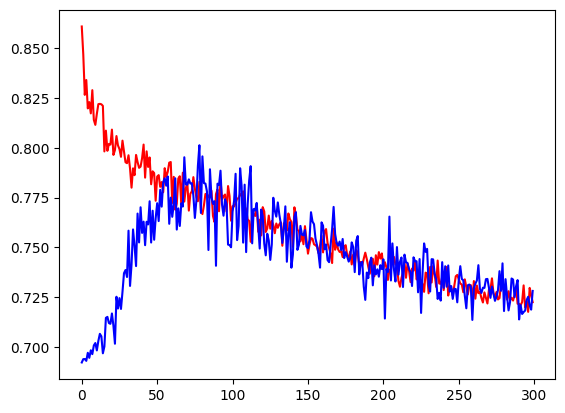

Train loss0.7176671624183655
Valid loss0.6922608017921448


In [12]:
import matplotlib.pyplot as plt
plt.plot(train_loss,'r')
plt.plot(valid_loss,'b')
plt.show()
print("Train loss" + str(min(train_loss)))
print("Valid loss" + str(min(valid_loss)))